Họ và tên: Phạm Đức Thể

MSSV: 19522253

Lớp: DS310.M11

Lab 03 - 28/10/2021

# Câu 1: Sử dụng mô hình LSTM để giải quyết bài toán NER cho tiếng Anh.

## Bước 1: Import Modules

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import seaborn as sn
import numpy as np
import requests
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.7.0
GPU detected: []


## Bước 2: Load bộ dữ liệu NER PhoNER_COVID19

<img src="https://user-images.githubusercontent.com/2412555/112276540-741ca100-8cb3-11eb-8191-9ba6cb83c72c.png" width="800" alt="PhoNER_COVID19" />





In [2]:
%cd /content
!git clone https://github.com/VinAIResearch/PhoNER_COVID19.git

/content
Cloning into 'PhoNER_COVID19'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 9), reused 17 (delta 7), pack-reused 0
Unpacking objects: 100% (32/32), done.


### Load tập train

In [3]:
data_train = pd.read_csv('/content/PhoNER_COVID19/data/word/train_word.conll', sep='\n\n', header=None)

Sentence_train = []
Word_train = []
Tag_train = []
flag_train = 0

for i in range(data_train.shape[0]):
  s = data_train[0][i].split()
  Sentence_train.append(flag_train)
  Word_train.append(s[0])
  Tag_train.append(s[1])
  if s[0] == '.':
    flag_train += 1

# Convert về dạng dataframe
df_train = pd.DataFrame({'Sentence': Sentence_train, 
                         'Word': Word_train,
                         'Tag': Tag_train})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
df_train

,Sentence,Word,Tag
0,0,Đồng_thời,O
1,0,",",O
2,0,bệnh_viện,O
3,0,tiếp_tục,O
4,0,thực_hiện,O
...,...,...,...
132506,4951,",",O
132507,4951,kết_quả,O
132508,4951,nghi,O
132509,4951,nhiễm,O


### Load tập dev

In [5]:
data_dev = pd.read_csv('/content/PhoNER_COVID19/data/word/dev_word.conll', sep='\n\n', header=None)

Sentence_dev = []
Word_dev = []
Tag_dev = []
flag_dev = flag_train

for i in range(data_dev.shape[0]):
  s = data_dev[0][i].split()
  Sentence_dev.append(flag_dev)
  Word_dev.append(s[0])
  Tag_dev.append(s[1])
  if s[0] == '.':
    flag_dev += 1

# Convert về dạng dataframe
df_dev = pd.DataFrame({'Sentence': Sentence_dev, 
                       'Word': Word_dev,
                       'Tag': Tag_dev})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
df_dev

,Sentence,Word,Tag
0,4952,Bác_sĩ,O
1,4952,Nguyễn_Trung_Nguyên,O
2,4952,",",O
3,4952,Giám_đốc,O
4,4952,Trung_tâm,B-ORGANIZATION
...,...,...,...
56278,6931,riêng,O
56279,6931,",",O
56280,6931,dương_tính,O
56281,6931,nCoV,O


### Load tập test

In [7]:
data_test = pd.read_csv('/content/PhoNER_COVID19/data/word/test_word.conll', sep='\n\n', header=None)

Sentence_test = []
Word_test = []
Tag_test = []
flag_test = flag_dev

for i in range(data_test.shape[0]):
  s = data_test[0][i].split()
  if len(s) < 2: # Vì lỗi ở dòng 14937 có word mà không có Tag nên ta sẽ bỏ qua từ này từ 'bệnh'
    continue
  Sentence_test.append(flag_test)
  Word_test.append(s[0])
  Tag_test.append(s[1])
  if s[0] == '.':
    flag_test += 1

# Convert về dạng dataframe
df_test = pd.DataFrame({'Sentence': Sentence_test, 
                        'Word': Word_test,
                        'Tag': Tag_test})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [8]:
df_test

,Sentence,Word,Tag
0,6932,Từ,O
1,6932,24,B-DATE
2,6932,-,I-DATE
3,6932,7,I-DATE
4,6932,đến,O
...,...,...,...
85672,9888,nhiệt_đới,I-LOCATION
85673,9888,trung_ương,I-LOCATION
85674,9888,cơ_sở,I-LOCATION
85675,9888,Đông_Anh,I-LOCATION


Lỗi ở dòng 14937 có word mà không có Tag

Merge 3 tập dữ liệu lại với nhau để thực hiện bước 4

In [9]:
data = pd.concat([df_train, df_dev, df_test], ignore_index=True)

In [10]:
data

,Sentence,Word,Tag
0,0,Đồng_thời,O
1,0,",",O
2,0,bệnh_viện,O
3,0,tiếp_tục,O
4,0,thực_hiện,O
...,...,...,...
274466,9888,nhiệt_đới,I-LOCATION
274467,9888,trung_ương,I-LOCATION
274468,9888,cơ_sở,I-LOCATION
274469,9888,Đông_Anh,I-LOCATION


## Visualizing the Sentenceentence
Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu. (Tập từ vựng, số chiều)
- Số lượng thẻ duy nhất trong tập dữ liệu. (Tập nhãn)


Bằng cách sử dụng hàm **“nunique”.**

In [11]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 8101
Unique tags in corpus: 21


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [12]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [13]:
print(words)
print(num_words)

['887', 'người', 'D.H', 'Phòng', 'L.P.A.', '12C', 'Hoàng_Văn_Thái', 'giờ_đây', 'lan_toả', 'phân', 'Duy_Sơn', 'sự_kiện', 'Cam_Phúc_Bắc', 'Quảng_Đại', '723', 'nhà_xe', 'đột_quỵ', 'dân', '628', '148', 'cứ', 'Dương', 'Tin', 'Cov', 'Việt', 'ta', 'giày', 'Xá', 'Loại_trừ', 'Mercure_Bà_Nà', 'thủ_thuật', 'Huyện', 'Thiện_Kế', 'bánh_mì', 'mặc', 'hộ_sinh', '24/6', 'quan_sát', 'Trung_Hoà', 'Vang', 'khẩn_trương', 'nhà_ga', 'N.P.H.', 'rét_mướt', 'Lão_khoa', 'xung', 'mắng_chửi', 'gợi', '780', 'sự_thật', 'Tuyến', 'Hương_Sen', 'tương_đồng', '19E', 'thành', 'quận_huyện', 'Daenam', 'Sóc_Sơn', 'Nguyễn_Tấn_Bỉnh', 'Nhân_Chính', '19/4', 'Tôi', 'tạo', 'Chiến', 'Quốc_Tử_Giám', '210', '616', 'nội_địa', 'VIP', 'T.V.M.H', 'Hiện', 'khác_biệt', 'tổn_thương', 'cấp', 'Viking_Cruise', 'út', 'căng_thẳng', '3', 'Thanh_Xá', 'yoga', 'trần', 'Trong', 'ngẫu_nhiên', '7131', 'ngày_đêm', 'Đông_Lễ', 'phim', 'Kyungbang', 'Thi_thể', 'tết_âm_lịch', '843', 'Vĩnh_Hà', 'vô_địch', '146', 'QH1524', 'Phong', '1/8', 'thận', 'Q.Gò', 

In [14]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [15]:
print(tags)

['I-ORGANIZATION', 'B-TRANSPORTATION', 'I-JOB', 'B-AGE', 'I-AGE', 'B-NAME', 'I-SYMPTOM_AND_DISEASE', 'B-GENDER', 'I-PATIENT_ID', 'B-LOCATION', 'B-DATE', 'B-ORGANIZATION', 'I-NAME', 'O-ORGANIZATION', 'O', 'I-TRANSPORTATION', 'B-SYMPTOM_AND_DISEASE', 'I-LOCATION', 'I-DATE', 'B-JOB', 'B-PATIENT_ID']


In [16]:
print('Tổng số từ duy nhất:', num_words)
print('Số lượng nhãn thực thể:', num_tags)

Tổng số từ duy nhất: 8102
Số lượng nhãn thực thể: 21


## Bước 3: Lấy các câu và các thẻ tương ứng

In [17]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

#các bạn có thể viết theo cách khác

In [18]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [19]:
sentences[1]

[('"', 'O'),
 ('Số', 'O'),
 ('bệnh_viện', 'O'),
 ('có_thể', 'O'),
 ('tiếp_nhận', 'O'),
 ('bệnh_nhân', 'O'),
 ('bị', 'O'),
 ('sốt', 'B-SYMPTOM_AND_DISEASE'),
 ('cao', 'I-SYMPTOM_AND_DISEASE'),
 ('và', 'O'),
 ('khó', 'B-SYMPTOM_AND_DISEASE'),
 ('thở', 'I-SYMPTOM_AND_DISEASE'),
 ('đang', 'O'),
 ('giảm', 'O'),
 ('dần', 'O'),
 ('"', 'O'),
 (',', 'O'),
 ('thông_cáo', 'O'),
 ('có', 'O'),
 ('đoạn', 'O'),
 (',', 'O'),
 ('cảnh_báo', 'O'),
 ('những', 'O'),
 ('bệnh_nhân', 'O'),
 ('này', 'O'),
 ('thay', 'O'),
 ('vào', 'O'),
 ('đó', 'O'),
 ('được', 'O'),
 ('chuyển', 'O'),
 ('tới', 'O'),
 ('các', 'O'),
 ('phòng_khám', 'O'),
 ('khẩn_cấp', 'O'),
 (',', 'O'),
 ('khiến', 'O'),
 ('những', 'O'),
 ('bệnh_nhân', 'O'),
 ('mắc', 'O'),
 ('bệnh', 'O'),
 ('hiểm_nghèo', 'O'),
 ('khác', 'O'),
 ('không', 'O'),
 ('có', 'O'),
 ('cơ_hội', 'O'),
 ('được', 'O'),
 ('điều_trị', 'O'),
 ('.', 'O')]

## Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [20]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [21]:
word2idx

{'887': 0,
 'người': 1,
 'D.H': 2,
 'Phòng': 3,
 'L.P.A.': 4,
 '12C': 5,
 'Hoàng_Văn_Thái': 6,
 'giờ_đây': 7,
 'lan_toả': 8,
 'phân': 9,
 'Duy_Sơn': 10,
 'sự_kiện': 11,
 'Cam_Phúc_Bắc': 12,
 'Quảng_Đại': 13,
 '723': 14,
 'nhà_xe': 15,
 'đột_quỵ': 16,
 'dân': 17,
 '628': 18,
 '148': 19,
 'cứ': 20,
 'Dương': 21,
 'Tin': 22,
 'Cov': 23,
 'Việt': 24,
 'ta': 25,
 'giày': 26,
 'Xá': 27,
 'Loại_trừ': 28,
 'Mercure_Bà_Nà': 29,
 'thủ_thuật': 30,
 'Huyện': 31,
 'Thiện_Kế': 32,
 'bánh_mì': 33,
 'mặc': 34,
 'hộ_sinh': 35,
 '24/6': 36,
 'quan_sát': 37,
 'Trung_Hoà': 38,
 'Vang': 39,
 'khẩn_trương': 40,
 'nhà_ga': 41,
 'N.P.H.': 42,
 'rét_mướt': 43,
 'Lão_khoa': 44,
 'xung': 45,
 'mắng_chửi': 46,
 'gợi': 47,
 '780': 48,
 'sự_thật': 49,
 'Tuyến': 50,
 'Hương_Sen': 51,
 'tương_đồng': 52,
 '19E': 53,
 'thành': 54,
 'quận_huyện': 55,
 'Daenam': 56,
 'Sóc_Sơn': 57,
 'Nguyễn_Tấn_Bỉnh': 58,
 'Nhân_Chính': 59,
 '19/4': 60,
 'Tôi': 61,
 'tạo': 62,
 'Chiến': 63,
 'Quốc_Tử_Giám': 64,
 '210': 65,
 '616': 66,
 '

In [22]:
tag2idx

{'B-AGE': 3,
 'B-DATE': 10,
 'B-GENDER': 7,
 'B-JOB': 19,
 'B-LOCATION': 9,
 'B-NAME': 5,
 'B-ORGANIZATION': 11,
 'B-PATIENT_ID': 20,
 'B-SYMPTOM_AND_DISEASE': 16,
 'B-TRANSPORTATION': 1,
 'I-AGE': 4,
 'I-DATE': 18,
 'I-JOB': 2,
 'I-LOCATION': 17,
 'I-NAME': 12,
 'I-ORGANIZATION': 0,
 'I-PATIENT_ID': 8,
 'I-SYMPTOM_AND_DISEASE': 6,
 'I-TRANSPORTATION': 15,
 'O': 14,
 'O-ORGANIZATION': 13}

## Bước 5: Padding  đầu vào và cắt dữ liệu thành tập Train/Test
Trong trục X, có thể thấy độ dài an toàn của câu là khoảng 80.

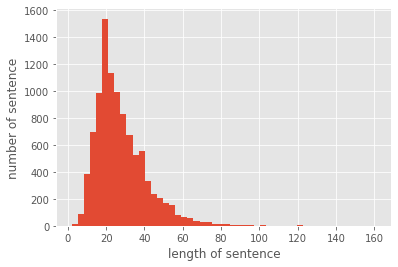

In [23]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 80
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [25]:
print(X[0])
print(y[0])

[7585 3699 3011 3769 7590 4817  753 7387 3783 2465 3691 3960 3275 2938
 6970 6742 7630  682 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
[14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 11  0 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14]


Chia lại tập train, dev, test

In [26]:
# tập train
X_train = X[0:flag_train]
y_train = y[0:flag_train]
# tập dev
X_dev = X[flag_train:flag_dev]
y_dev = y[flag_train:flag_dev]
# tập test
X_test = X[flag_dev:]
y_test = y[flag_dev:]

## Bước 6: Xây dựng Mô hình GRU hai chiều (bi-GRU)


In [27]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GRU, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

Bản tóm tắt cho thấy rằng chúng ta có hơn 761 nghìn tham số cần được huấn luyện.

In [28]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=80, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(GRU(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80)]              0         
                                                                 
 embedding (Embedding)       (None, 80, 80)            648160    
                                                                 
 spatial_dropout1d (SpatialD  (None, 80, 80)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 80, 200)          109200    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 80, 21)           4221      
 ibuted)                                                         
                                                             

- Sử dụng trình tối ưu hoá "adam"
- sparce_categorical_crossentropy làm hàm mất mát
- Ma trận mà chúng ta sẽ quan tâm là ma trận độ chính xác.

In [29]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# Dừng sớm để tránh overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Bước 7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [30]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(X_train, y_train, validation_data=(X_dev, y_dev),
                    batch_size= 32, epochs=10, callbacks=[callback])

print("[{}] Completed!".format(time.time() - start_time))

Epoch 1/10
155/155 [==============================] - 46s 265ms/step - loss: 0.5241 - accuracy: 0.9221 - val_loss: 0.2701 - val_accuracy: 0.9266
Epoch 2/10
155/155 [==============================] - 41s 262ms/step - loss: 0.1465 - accuracy: 0.9590 - val_loss: 0.1468 - val_accuracy: 0.9611
Epoch 3/10
155/155 [==============================] - 41s 264ms/step - loss: 0.0705 - accuracy: 0.9819 - val_loss: 0.0913 - val_accuracy: 0.9764
Epoch 4/10
155/155 [==============================] - 41s 262ms/step - loss: 0.0422 - accuracy: 0.9891 - val_loss: 0.0788 - val_accuracy: 0.9799
Epoch 5/10
155/155 [==============================] - 41s 262ms/step - loss: 0.0301 - accuracy: 0.9922 - val_loss: 0.0657 - val_accuracy: 0.9827
Epoch 6/10
155/155 [==============================] - 41s 262ms/step - loss: 0.0235 - accuracy: 0.9935 - val_loss: 0.0650 - val_accuracy: 0.9834
Epoch 7/10
155/155 [==============================] - 41s 262ms/step - loss: 0.0192 - accuracy: 0.9948 - val_loss: 0.0621 - val_ac

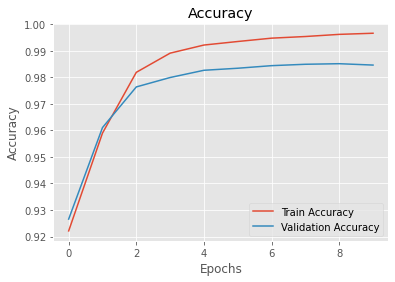

In [31]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

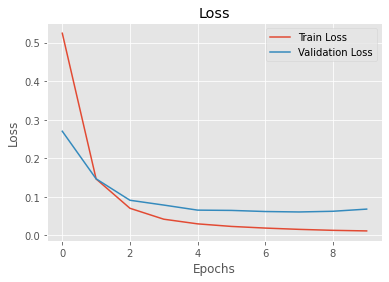

In [32]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Bước 8: Đánh giá mô hình NER



In [33]:
model.evaluate(X_test, y_test)

93/93 [==============================] - 3s 34ms/step - loss: 0.0817 - accuracy: 0.9827


[0.08169751614332199, 0.9826639890670776]

- Dự đoán

In [34]:
# i = np.random.randint(0, X_test.shape[0]) #659
print(X_test[0])
i = 2
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:25}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:25}{:10}\t{}".format(words[w], tags[true], tags[pred]))

[5220 3802 3691 3514 4927  277 3691 3514 3699 4612 4453 5168 6939 7395
 3913  664 4993  531 3896 6002 2966 7265 3824 5881 6151  664 5872  746
 3896 3699 3742 7948 3466 1276  309 2329 6692 3699 2119 6137 3699 5881
 1852 2393 5168  156 7631 3824 4484  682 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
Word                     True      	 Pred

------------------------------
Theo                     O         	O
đó                       O         	O
,                        O         	O
Sở                       B-ORGANIZATION	B-ORGANIZATION
Y_tế                     I-ORGANIZATION	I-ORGANIZATION
Bình_Thuận               I-ORGANIZATION	I-ORGANIZATION
cho                      O         	O
biết                     O         	O
sau                      O         	O
khi                      O         	O
xác_định                 O         	O
bệnh_nhân                O         	O
số          

## Bước 9: Yêu cầu

### Đánh giá mô hình theo độ đo F1-score

In [35]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=a7ab761cb4c09af46c6ed1878e11bd509a63d90cf07f0389e98a7db43bb08718
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


predict tập test

In [36]:
y_true = []
y_pred = []
for i in range(y_test.shape[0]):
  y_true.append(y_test[i])
  p = model.predict(np.array([X_test[i]]))
  p = np.argmax(p, axis=-1)
  y_pred.extend(p)

In [37]:
Y_true = []
Y_pred = []

for i, j in zip(range(len(y_true)), range(len(y_pred))):
  true = []
  pred = []
  for k in range(len(y_true[i])):
    true.append(tags[y_true[i][k]])
    pred.append(tags[y_pred[j][k]])
  Y_true.append(true)
  Y_pred.append(pred)

In [38]:
from seqeval.metrics import f1_score

print('F1-score micro test set: {}%'.format(round(f1_score(Y_true, Y_pred, average='micro')*100,2)))
print('F1-score macro test set: {}%'.format(round(f1_score(Y_true, Y_pred, average='macro')*100,2)))

F1-score micro test set: 83.95%
F1-score macro test set: 77.35%


### F1-score và Accuracy cho từng nhãn thực thể. 

#### F1-score

In [39]:
from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  """Entry point for launching an IPython kernel.


In [40]:
YT = list(flatten(Y_true))
YP = list(flatten(Y_pred))

In [41]:
from sklearn.metrics import classification_report as sklearn_cs

print(sklearn_cs(YT, YP))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                B-AGE       0.94      0.92      0.93       568
               B-DATE       0.98      0.96      0.97      1640
             B-GENDER       0.97      0.88      0.92       447
                B-JOB       0.82      0.35      0.49       172
           B-LOCATION       0.93      0.89      0.91      4425
               B-NAME       0.94      0.54      0.69       317
       B-ORGANIZATION       0.88      0.81      0.84       769
         B-PATIENT_ID       0.96      0.87      0.91      1978
B-SYMPTOM_AND_DISEASE       0.91      0.79      0.85      1134
     B-TRANSPORTATION       0.94      0.58      0.72       193
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.97      0.99      0.98      1726
                I-JOB       0.67      0.09      0.16       114
           I-LOCATION       0.94      0.81      0.87      4892
               I-NAME       0.00      0.00      0.00  

In [42]:
from seqeval.metrics import classification_report as seqeval_cs

print(seqeval_cs(Y_true, Y_pred, digits =4))

                     precision    recall  f1-score   support

                AGE     0.9320    0.9173    0.9246       568
               DATE     0.9545    0.9464    0.9505      1642
             GENDER     0.9657    0.8814    0.9216       447
                JOB     0.6625    0.3081    0.4206       172
           LOCATION     0.8299    0.8213    0.8256      4426
               NAME     0.9176    0.5268    0.6693       317
       ORGANIZATION     0.7064    0.7156    0.7110       770
         PATIENT_ID     0.9564    0.8650    0.9084      1978
SYMPTOM_AND_DISEASE     0.7649    0.7143    0.7387      1134
     TRANSPORTATION     0.8618    0.5408    0.6646       196

          micro avg     0.8648    0.8156    0.8395     11650
          macro avg     0.8552    0.7237    0.7735     11650
       weighted avg     0.8651    0.8156    0.8368     11650



#### Accuracy

In [43]:
from seqeval.metrics import accuracy_score

accuracy = round(accuracy_score(Y_true, Y_pred)*100,2)
print('Accuracy test = {}%'.format(accuracy))

Accuracy test = 98.27%


Confusion matrix với các nhãn tương ứng như sau

B-AGE - 0     
B-DATE - 1        
B-GENDER - 2        
B-JOB - 3        
B-LOCATION - 4        
B-NAME - 5        
B-ORGANIZATION - 6        
B-PATIENT_ID - 7        
B-SYMPTOM_AND_DISEASE - 8        
B-TRANSPORTATION - 9        
I-AGE - 10        
I-DATE - 11       
I-JOB - 12        
I-LOCATION - 12        
I-NAME - 14        
I-ORGANIZATION - 15        
I-PATIENT_ID - 16        
I-SYMPTOM_AND_DISEASE - 17        
I-TRANSPORTATION - 18        
O - 19        

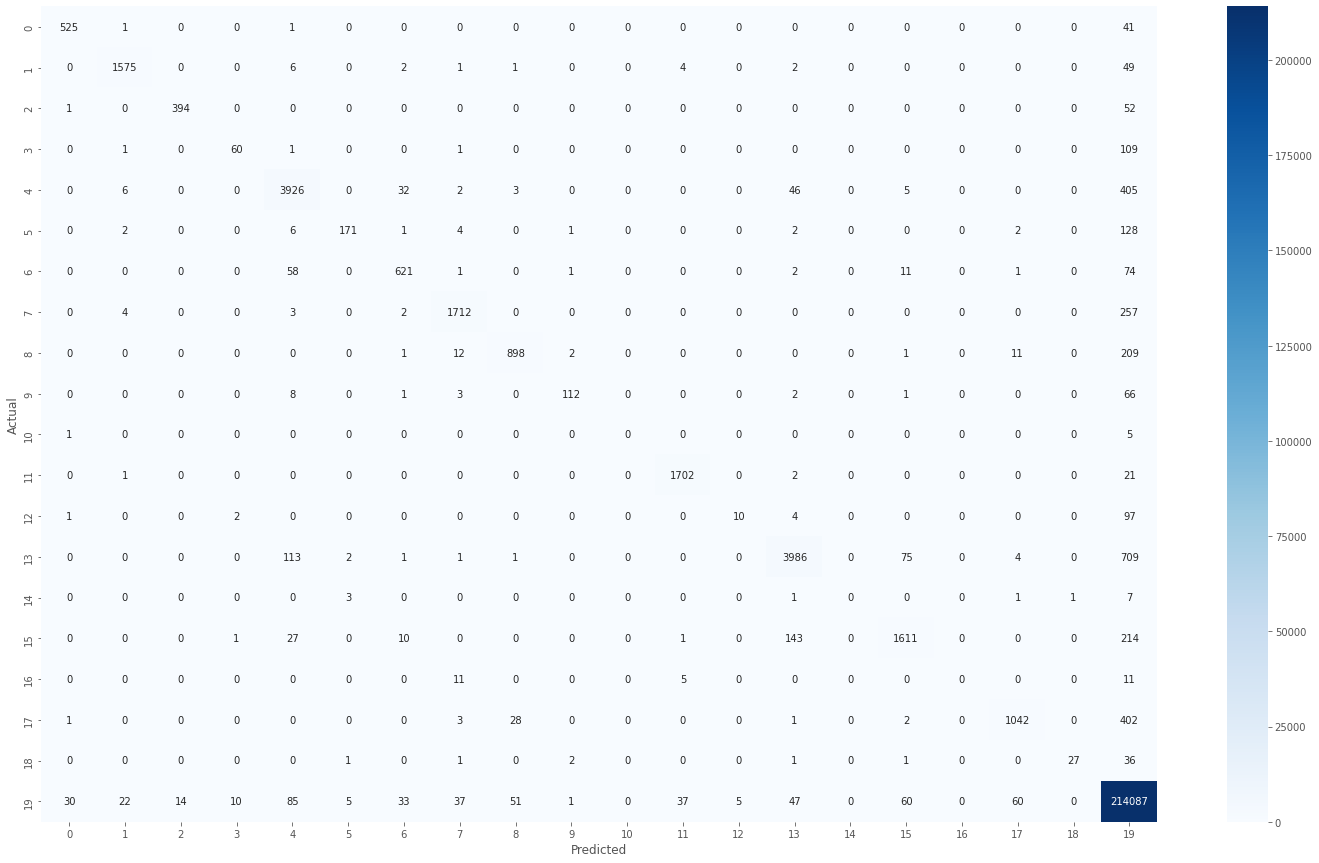

In [44]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(YT, YP) 
plt.figure(figsize=(25,15))
sn.heatmap(cm, annot=True, cmap = 'Blues', fmt='g', cbar=True, annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [45]:
labels=['B-AGE', 'B-DATE', 'B-GENDER', 'B-JOB', 'B-LOCATION', 'B-NAME', 'B-ORGANIZATION', 'B-PATIENT_ID', 'B-SYMPTOM_AND_DISEASE', 'B-TRANSPORTATION', 
        'I-AGE', 'I-DATE', 'I-JOB', 'I-LOCATION', 'I-NAME', 'I-ORGANIZATION', 'I-PATIENT_ID', 'I-SYMPTOM_AND_DISEASE', 'I-TRANSPORTATION', 'O' ]
# Accuracy của từng nhãn thực thể
acc_class = cm.diagonal()/cm.sum(axis=1) 
df_acc_class = pd.DataFrame({'Label': labels,
                             'Accuracy': acc_class})
df_acc_class

,Label,Accuracy
0,B-AGE,0.924296
1,B-DATE,0.960366
2,B-GENDER,0.881432
3,B-JOB,0.348837
4,B-LOCATION,0.887232
5,B-NAME,0.539432
6,B-ORGANIZATION,0.807542
7,B-PATIENT_ID,0.865521
8,B-SYMPTOM_AND_DISEASE,0.791887
9,B-TRANSPORTATION,0.580311


### Lưu lại mô hình và bộ trọng số đã train. 

In [46]:
# Chuyển đến thư mục cần lưu model
%cd '/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021'

/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021


In [47]:
pwd

'/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021'

In [48]:
ls

BTTH3_19522253.pdf                 NER_Câu2_GRU_19522253_model.h5
NER_Câu1_GRU_19522253.ipynb        NER_Câu2_GRU_19522253_weights.h5
NER_Câu1_GRU_19522253_model.h5     NER_Câu2_LSTM_19522253.ipynb
NER_Câu1_GRU_19522253_weights.h5   NER_Câu2_LSTM_19522253_model.h5
NER_Câu1_LSTM_19522253.ipynb       NER_Câu2_LSTM_19522253_weights.h5
NER_Câu1_LSTM_19522253_model.h5    NER_Câu2_RNN_19522253_model.h5
NER_Câu1_LSTM_19522253_weights.h5  NER_Câu2_RNN_19522253_weights.h5
NER_Câu1_RNN_19522253_model.h5     ner_dataset.csv
NER_Câu1_RNN_19522253_weights.h5   NER-LSTM.ipynb
NER_Câu2_GRU_19522253.ipynb


In [49]:
# Lưu bộ trọng số đã train
model.save_weights('NER_Câu2_GRU_19522253_weights.h5')

In [50]:
# Lưu mô hình đã train
model.save('NER_Câu2_GRU_19522253_model.h5')